In [1]:
import numpy as np
import pandas as pd
from aif360.datasets import CompasDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import BinaryLabelDatasetMetric

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2024-01-02 19:16:18.731572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 19:16:18.731607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 19:16:18.732421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 19:16:18.736797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical o

In [2]:
%matplotlib inline
# Load all necessary packages
# import sys
# sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from common_utils import compute_metrics

In [3]:
# Load the COMPAS dataset
compas_data = CompasDataset()
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

In [4]:
# Exercise 1: Fix bias using race as the protected attribute, and measure bias assuming sex as the protected attribute
compas_data_train, compas_data_test = compas_data.split([0.7], shuffle=True)

biased_metric_race = BinaryLabelDatasetMetric(compas_data_test, unprivileged_groups, privileged_groups)
print("Original Bias (race as protected attribute):", biased_metric_race.disparate_impact())

Original Bias (race as protected attribute): 0.83629636216548


In [5]:
# Apply reweighing to mitigate bias
reweighing = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
reweighted_data_race_train = reweighing.fit_transform(compas_data_train)
reweighted_data_race_test = reweighing.transform(compas_data_test)

reweighted_metric_race = BinaryLabelDatasetMetric(reweighted_data_race_test, unprivileged_groups, privileged_groups)
print("Bias after Reweighing (race as protected attribute):", reweighted_metric_race.disparate_impact())


Bias after Reweighing (race as protected attribute): 0.9979570386846045


In [6]:
# Measure bias assuming sex as the protected attribute
privileged_groups_sex = [{'sex': 1}]
unprivileged_groups_sex = [{'sex': 0}]

biased_metric_sex = BinaryLabelDatasetMetric(compas_data_test, unprivileged_groups_sex, privileged_groups_sex)
print("Original Bias (sex as protected attribute):", biased_metric_sex.disparate_impact())


Original Bias (sex as protected attribute): 0.8248767123287672


In [7]:
# Apply reweighing to mitigate bias
reweighing_sex = Reweighing(unprivileged_groups=unprivileged_groups_sex, privileged_groups=privileged_groups_sex)
reweighted_data_sex_train = reweighing_sex.fit_transform(compas_data_train)
reweighted_data_sex_test = reweighing_sex.transform(compas_data_test)

reweighted_metric_sex = BinaryLabelDatasetMetric(reweighted_data_sex_test, unprivileged_groups_sex, privileged_groups_sex)
print("Bias after Reweighing (sex as protected attribute):", reweighted_metric_sex.disparate_impact())

Bias after Reweighing (sex as protected attribute): 1.057016315863342


In [8]:
# Exercise 2: Fix bias using sex as the protected attribute, and measure bias assuming race as the protected attribute
compas_data_train, compas_data_test = compas_data.split([0.7], shuffle=True)

biased_metric_sex = BinaryLabelDatasetMetric(compas_data_test, unprivileged_groups, privileged_groups)
print("Original Bias (sex as protected attribute):", biased_metric_sex.disparate_impact())

# Apply reweighing to mitigate bias
reweighing_sex = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
reweighted_data_sex_train = reweighing_sex.fit_transform(compas_data_train)
reweighted_data_sex_test = reweighing_sex.transform(compas_data_test)

reweighted_metric_sex = BinaryLabelDatasetMetric(reweighted_data_sex_test, unprivileged_groups, privileged_groups)
print("Bias after Reweighing (sex as protected attribute):", reweighted_metric_sex.disparate_impact())

# Measure bias assuming race as the protected attribute
privileged_groups_race = [{'race': 1}]
unprivileged_groups_race = [{'race': 0}]

biased_metric_race = BinaryLabelDatasetMetric(compas_data_test, unprivileged_groups_race, privileged_groups_race)
print("Original Bias (race as protected attribute):", biased_metric_race.disparate_impact())

# Apply reweighing to mitigate bias
reweighing_race = Reweighing(unprivileged_groups=unprivileged_groups_race, privileged_groups=privileged_groups_race)
reweighted_data_race_train = reweighing_race.fit_transform(compas_data_train)
reweighted_data_race_test = reweighing_race.transform(compas_data_test)

reweighted_metric_race = BinaryLabelDatasetMetric(reweighted_data_race_test, unprivileged_groups_race, privileged_groups_race)
print("Bias after Reweighing (race as protected attribute):", reweighted_metric_race.disparate_impact())

Original Bias (sex as protected attribute): 0.8433356214035066
Bias after Reweighing (sex as protected attribute): 1.0050299006335417
Original Bias (race as protected attribute): 0.8433356214035066
Bias after Reweighing (race as protected attribute): 1.0050299006335417


In [9]:
# Exercise 3: Repeat measurements considering age groups
# For simplicity, let's assume two age groups: less than 25 and 25 or older
compas_data_train, compas_data_test = compas_data.split([0.7], shuffle=True)

# Create age groups in the train and test datasets
compas_data_train.features[:, compas_data_train.feature_names.index('age')] = np.where(
    compas_data_train.features[:, compas_data_train.feature_names.index('age')] < 25, 0, 1
)

compas_data_test.features[:, compas_data_test.feature_names.index('age')] = np.where(
    compas_data_test.features[:, compas_data_test.feature_names.index('age')] < 25, 0, 1
)

# Bias mitigation and measurement for age as the protected attribute
biased_metric_age = BinaryLabelDatasetMetric(compas_data_test, unprivileged_groups, privileged_groups)
print("Original Bias (age < 25 as protected attribute):", biased_metric_age.disparate_impact())

# Apply reweighing to mitigate bias
reweighing_age = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
reweighted_data_age_train = reweighing_age.fit_transform(compas_data_train)
reweighted_data_age_test = reweighing_age.transform(compas_data_test)

reweighted_metric_age = BinaryLabelDatasetMetric(reweighted_data_age_test, unprivileged_groups, privileged_groups)
print("Bias after Reweighing (age < 25 as protected attribute):", reweighted_metric_age.disparate_impact())

Original Bias (age < 25 as protected attribute): 0.85709516515455
Bias after Reweighing (age < 25 as protected attribute): 1.028120130842867


## race as protected attribute logistic regression classifier

In [10]:
# label_map = {1.0: 'Did recid.', 0.0: 'No recid.'}
# protected_attribute_maps = [{1.0: 'race', 0.0: 'race'}]
# cd = CompasDataset(protected_attribute_names=['race'], 
#                    privileged_classes=[['Male']], metadata={'label_map': label_map, 
#                   'protected_attribute_maps': protected_attribute_maps})

In [11]:
compas_data = CompasDataset(
    protected_attribute_names=['race'], 
    privileged_classes=[['Caucasian']],  # Assuming 'Caucasian' as privileged
    features_to_drop=['sex']  # Drop 'sex' to avoid the conversion error
)

privileged_groups_sex = [{'sex': 1}]
unprivileged_groups_sex = [{'sex': 0}]

In [12]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = compas_data.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = compas_data.split([0.3], shuffle=True)

#### Clean up training data

In [13]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(4316, 400)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'age_cat=25 - 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'c_charge_degree=F', 'c_charge_degree=M', 'c_charge_desc=Abuse Without Great Harm', 'c_charge_desc=Agg Abuse Elderlly/Disabled Adult', 'c_charge_desc=Agg Assault W/int Com Fel Dome', 'c_charge_desc=Agg Battery Grt/Bod/Harm', 'c_charge_desc=Agg Fleeing and Eluding', 'c_charge_desc=Agg Fleeing/Eluding High Speed', 'c_charge_desc=Aggr Child Abuse-Torture,Punish', 'c_charge_desc=Aggrav Battery w/Deadly Weapon', 'c_charge_desc=Aggrav Child Abuse-Agg Battery', 'c_charge_desc=Aggrav Child Abuse-Causes Harm', 'c_charge_desc=Aggrav Stalking After Injunctn', 'c_charge_desc=Aggravated Assault', 'c_charge_desc=Aggravated Assault W/Dead Weap', 'c_charge_desc=Aggravated Assault W/dead Weap', 'c_charge_desc=Aggravated Assault W/o Firearm', 'c_charge_desc=Aggravated Assault w/Firearm', 'c_charge_desc=Aggravated Battery', 'c_charge_desc=Aggravated B

In [14]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.083851


In [15]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [16]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [17]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [18]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

### Train classifier on original data

In [19]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [20]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_orig_valid_pred.scores[:10])

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[0.60032126]
 [0.6546156 ]
 [0.40212305]
 [0.99871835]
 [0.19277356]
 [0.0617856 ]
 [0.46337052]
 [0.29050037]
 [0.34310019]
 [0.32272915]]


### Find the optimal classification threshold from the validation set

In [21]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6844
Optimal classification threshold (no reweighing) = 0.5247


### Predictions from the original test set at the optimal classification threshold

In [22]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.5247


 33%|███▎      | 33/100 [00:00<00:00, 327.50it/s]

Balanced accuracy = 0.6951
Statistical parity difference = -0.1188
Disparate impact = 0.8167
Average odds difference = -0.0936
Equal opportunity difference = -0.0643
Theil index = 0.1959


100%|██████████| 100/100 [00:00<00:00, 337.50it/s]


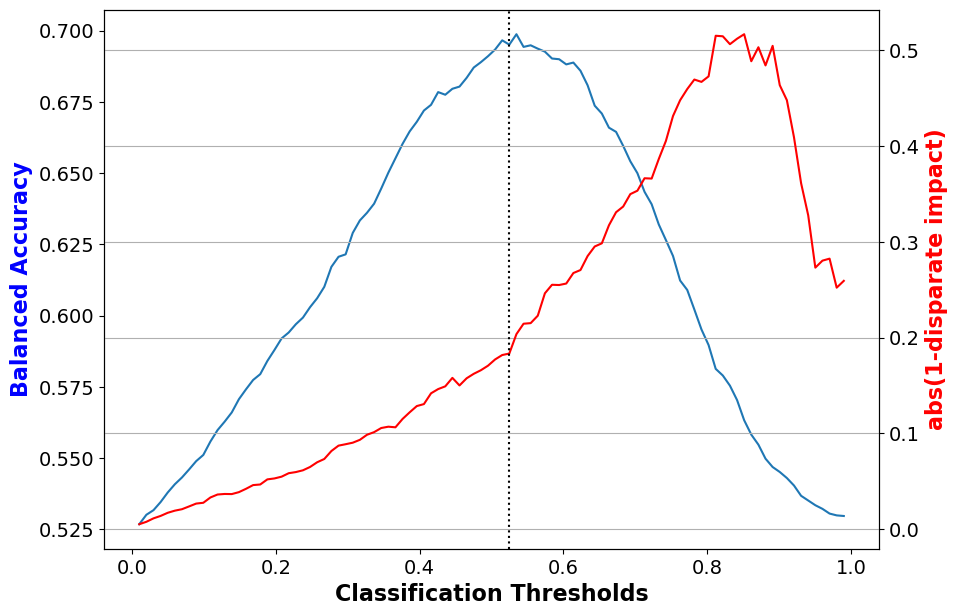

In [23]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

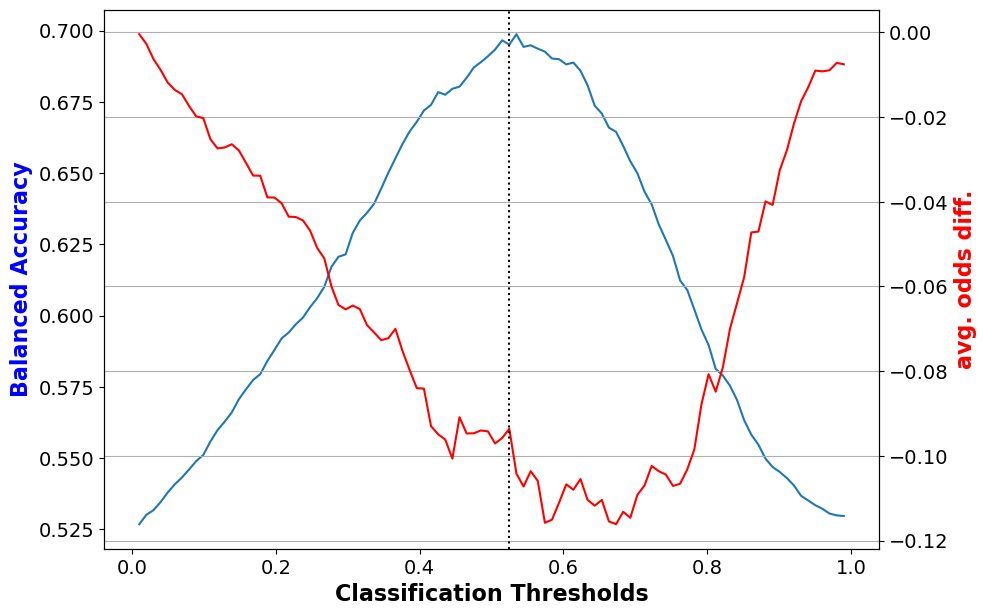

In [24]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

### Train classifier on transformed data

In [25]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [26]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [27]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.5247


 25%|██▌       | 25/100 [00:00<00:00, 245.36it/s]

Balanced accuracy = 0.6924
Statistical parity difference = 0.0041
Disparate impact = 1.0072
Average odds difference = 0.0315
Equal opportunity difference = 0.0473
Theil index = 0.1956


100%|██████████| 100/100 [00:00<00:00, 294.54it/s]


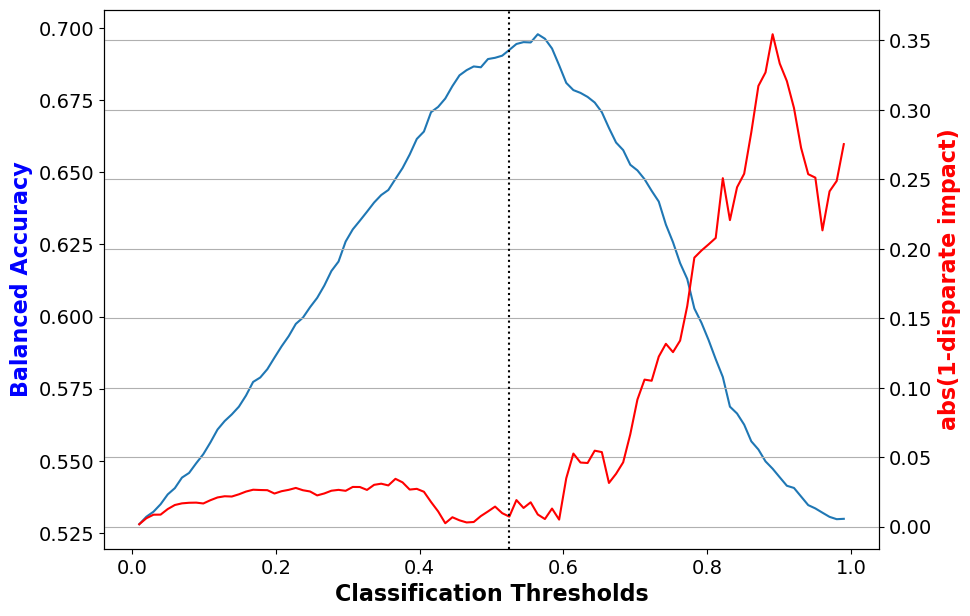

In [28]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

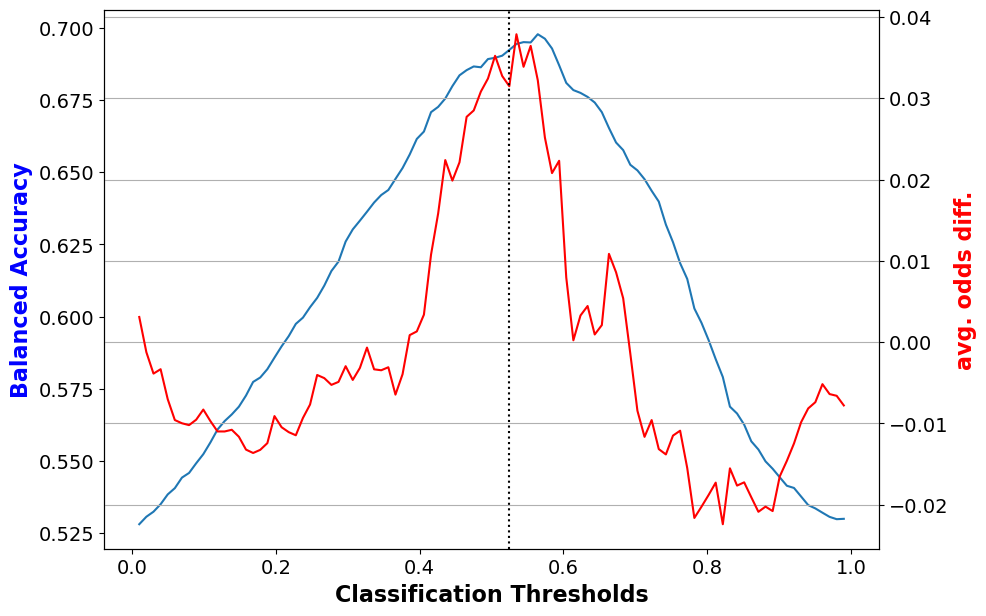

In [29]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

## Sex as protected attribute logistic regression classifier

In [30]:
compas_data = CompasDataset(
    protected_attribute_names=['sex'], 
    privileged_classes=[['Male']],  # Assuming 'Caucasian' as privileged
    features_to_drop=['race']  # Drop 'sex' to avoid the conversion error
)

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

In [31]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = compas_data.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = compas_data.split([0.3], shuffle=True)

#### Clean up training data

In [32]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(4316, 400)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'age_cat=25 - 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'c_charge_degree=F', 'c_charge_degree=M', 'c_charge_desc=Abuse Without Great Harm', 'c_charge_desc=Agg Abuse Elderlly/Disabled Adult', 'c_charge_desc=Agg Assault W/int Com Fel Dome', 'c_charge_desc=Agg Battery Grt/Bod/Harm', 'c_charge_desc=Agg Fleeing and Eluding', 'c_charge_desc=Agg Fleeing/Eluding High Speed', 'c_charge_desc=Aggr Child Abuse-Torture,Punish', 'c_charge_desc=Aggrav Battery w/Deadly Weapon', 'c_charge_desc=Aggrav Child Abuse-Agg Battery', 'c_charge_desc=Aggrav Child Abuse-Causes Harm', 'c_charge_desc=Aggrav Stalking After Injunctn', 'c_charge_desc=Aggravated Assault', 'c_charge_desc=Aggravated Assault W/Dead Weap', 'c_charge_desc=Aggravated Assault W/dead Weap', 'c_charge_desc=Aggravated Assault W/o Firearm', 'c_charge_desc=Aggravated Assault w/Firearm', 'c_charge_desc=Aggravated Battery', 'c_charge_desc=Aggravated Ba

In [33]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.136049


In [34]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [35]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [36]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [37]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

### Train classifier on original data

In [38]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [39]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_orig_valid_pred.scores[:10])

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[0.36968114]
 [0.75823816]
 [0.61706784]
 [0.67517697]
 [0.89847877]
 [0.53699159]
 [0.85843453]
 [0.87076771]
 [0.4799212 ]
 [0.74462371]]


### Find the optimal classification threshold from the validation set

In [40]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6974
Optimal classification threshold (no reweighing) = 0.5445


### Predictions from the original test set at the optimal classification threshold

In [41]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.5445


 32%|███▏      | 32/100 [00:00<00:00, 318.83it/s]

Balanced accuracy = 0.6910
Statistical parity difference = 0.2576
Disparate impact = 1.5248
Average odds difference = 0.2311
Equal opportunity difference = 0.1801
Theil index = 0.2177


100%|██████████| 100/100 [00:00<00:00, 342.33it/s]


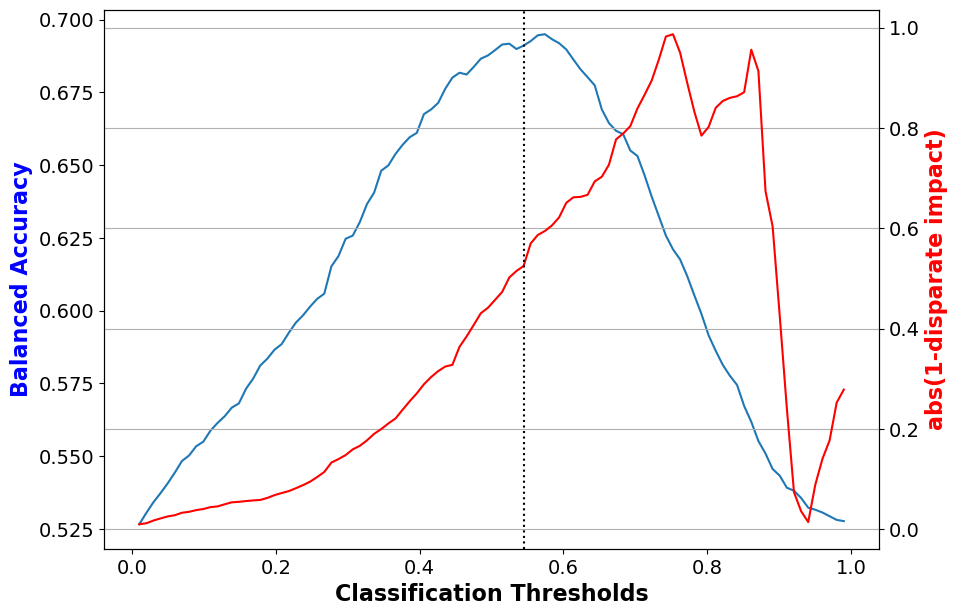

In [42]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

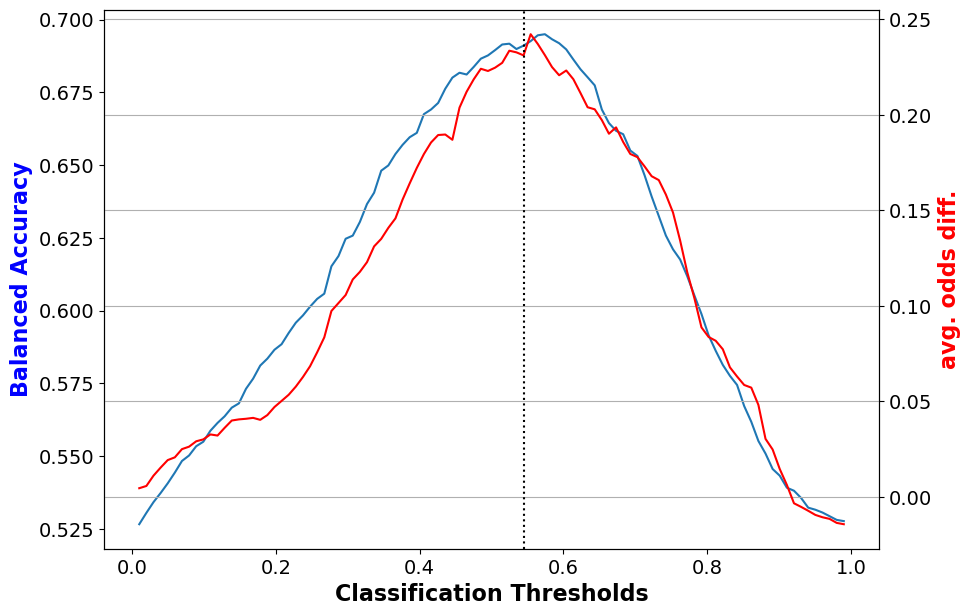

In [43]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

### Train classifier on transformed data

In [44]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [45]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [46]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.5445


 25%|██▌       | 25/100 [00:00<00:00, 249.95it/s]

Balanced accuracy = 0.6844
Statistical parity difference = 0.0175
Disparate impact = 1.0333
Average odds difference = -0.0129
Equal opportunity difference = -0.0480
Theil index = 0.2290


100%|██████████| 100/100 [00:00<00:00, 318.90it/s]


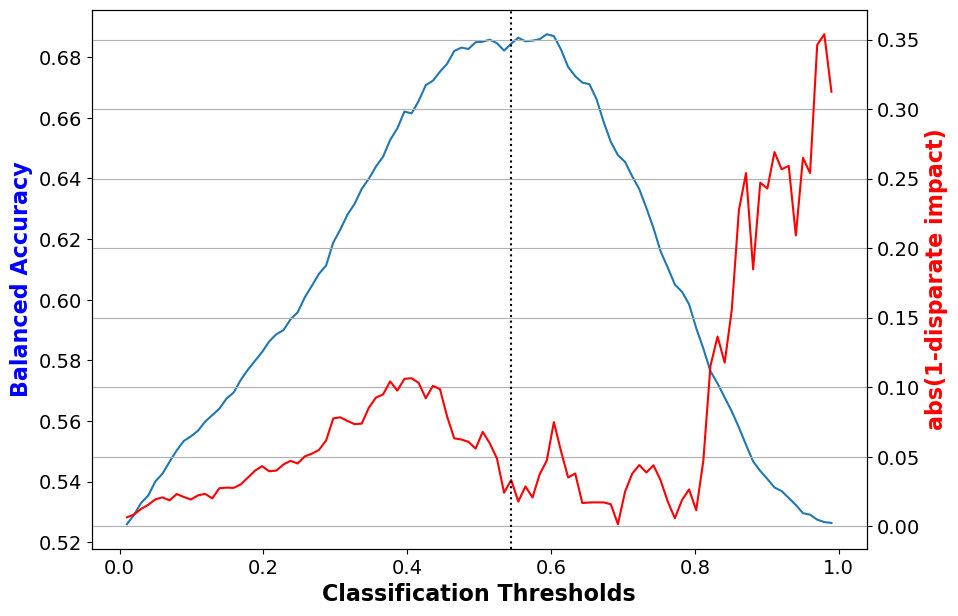

In [47]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

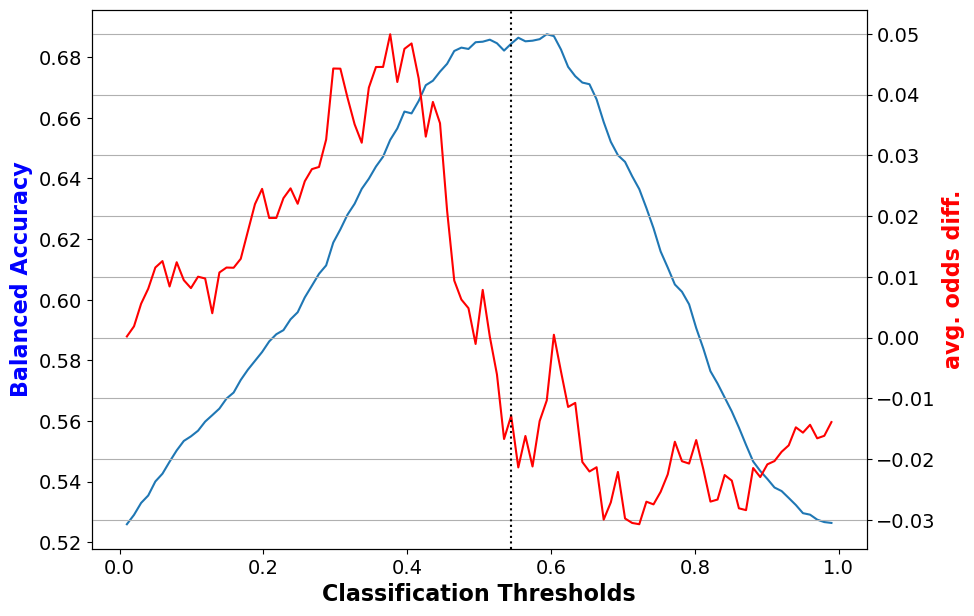

In [48]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

## Sex, race as protected attribute, age < 25, logistic regression classifier

In [49]:
# Load the dataset with 'sex' and 'race' as protected attributes
compas_data = CompasDataset(
    protected_attribute_names=['sex', 'race'],
    privileged_classes=[['Male'], ['Caucasian']],  # 'Male' for 'sex' and 'Caucasian' for 'race'
    features_to_drop=[]  # No features to drop initially
)

# Filter the dataset for individuals aged less than 25
compas_data = compas_data.subset(compas_data.features[:, compas_data.feature_names.index('age')] < 25)

# Define privileged and unprivileged groups for both 'sex' and 'race'
privileged_groups = [{'sex': 1, 'race': 1}]
unprivileged_groups = [{'sex': 0, 'race': 0}]

In [50]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = compas_data.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = compas_data.split([0.3], shuffle=True)

#### Clean up training data

In [51]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(942, 401)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'age_cat=25 - 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'c_charge_degree=F', 'c_charge_degree=M', 'c_charge_desc=Abuse Without Great Harm', 'c_charge_desc=Agg Abuse Elderlly/Disabled Adult', 'c_charge_desc=Agg Assault W/int Com Fel Dome', 'c_charge_desc=Agg Battery Grt/Bod/Harm', 'c_charge_desc=Agg Fleeing and Eluding', 'c_charge_desc=Agg Fleeing/Eluding High Speed', 'c_charge_desc=Aggr Child Abuse-Torture,Punish', 'c_charge_desc=Aggrav Battery w/Deadly Weapon', 'c_charge_desc=Aggrav Child Abuse-Agg Battery', 'c_charge_desc=Aggrav Child Abuse-Causes Harm', 'c_charge_desc=Aggrav Stalking After Injunctn', 'c_charge_desc=Aggravated Assault', 'c_charge_desc=Aggravated Assault W/Dead Weap', 'c_charge_desc=Aggravated Assault W/dead Weap', 'c_charge_desc=Aggravated Assault W/o Firearm', 'c_charge_desc=Aggravated Assault w/Firearm', 'c_charge_desc=Aggravated Battery', 'c_charge_desc=Aggra

In [52]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.147837


In [53]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [54]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [55]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


In [56]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

### Train classifier on original data

In [57]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [58]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_orig_valid_pred.scores[:10])

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[2.27746352e-01]
 [3.60172881e-01]
 [8.49646761e-02]
 [2.69766969e-01]
 [7.66671646e-01]
 [8.34386697e-01]
 [2.36345714e-01]
 [3.79174632e-01]
 [3.32468165e-01]
 [5.68324330e-04]]


### Find the optimal classification threshold from the validation set

In [59]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.7302
Optimal classification threshold (no reweighing) = 0.3862


### Predictions from the original test set at the optimal classification threshold

In [60]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.3862


 93%|█████████▎| 93/100 [00:00<00:00, 928.72it/s]

Balanced accuracy = 0.6870
Statistical parity difference = 0.1614
Disparate impact = 1.2402
Average odds difference = 0.1378
Equal opportunity difference = 0.0807
Theil index = 0.1675


100%|██████████| 100/100 [00:00<00:00, 917.79it/s]


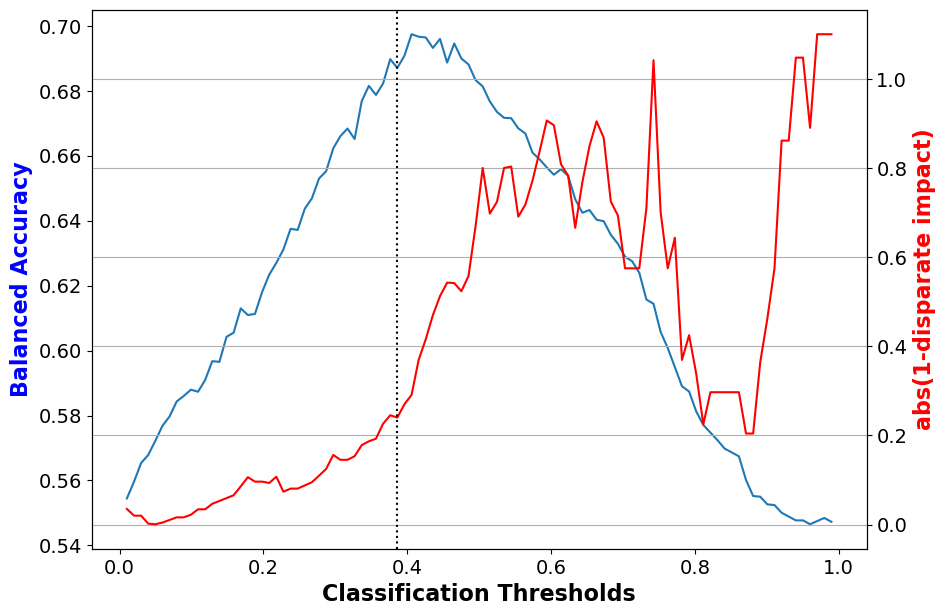

In [61]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

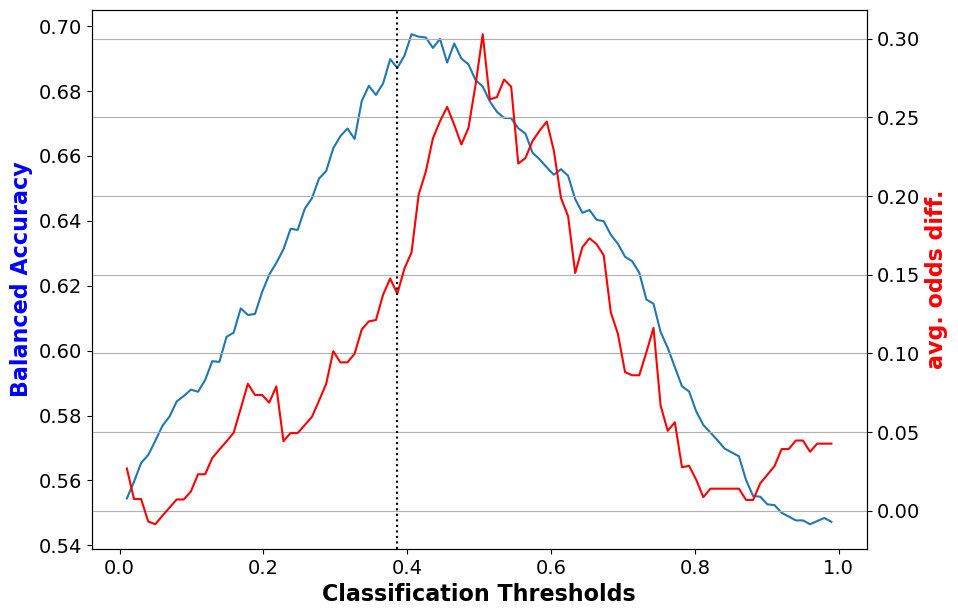

In [62]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

### Train classifier on transformed data

In [63]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [64]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [65]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.3862


100%|██████████| 100/100 [00:00<00:00, 805.69it/s]

Balanced accuracy = 0.6844
Statistical parity difference = 0.0386
Disparate impact = 1.0584
Average odds difference = 0.0144
Equal opportunity difference = -0.0261
Theil index = 0.1904


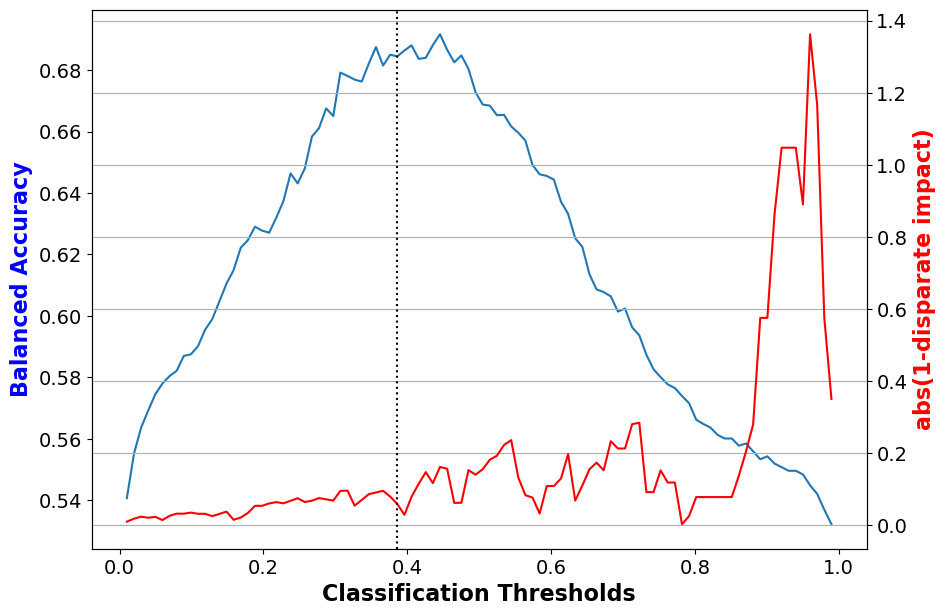

In [66]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

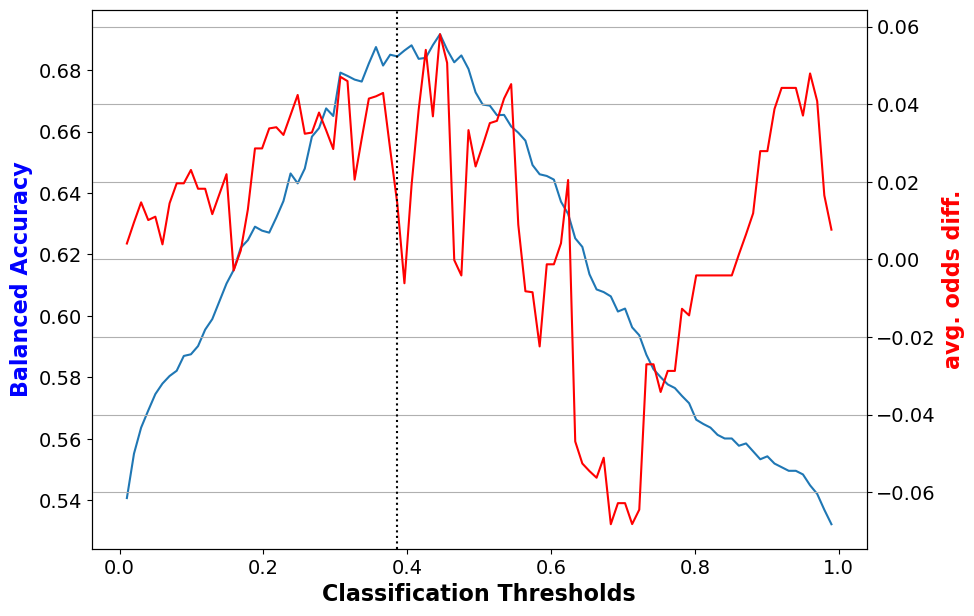

In [67]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

## Sex, race as protected attribute, age > 25, logistic regression classifier

In [68]:
# Load the dataset with 'sex' and 'race' as protected attributes
compas_data = CompasDataset(
    protected_attribute_names=['sex', 'race'],
    privileged_classes=[['Male'], ['Caucasian']],  # 'Male' for 'sex' and 'Caucasian' for 'race'
    features_to_drop=[]  # No features to drop initially
)

# Filter the dataset for individuals aged less than 25
compas_data = compas_data.subset(compas_data.features[:, compas_data.feature_names.index('age')] > 25)

# Define privileged and unprivileged groups for both 'sex' and 'race'
privileged_groups = [{'sex': 1, 'race': 1}]
unprivileged_groups = [{'sex': 0, 'race': 0}]

In [69]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = compas_data.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = compas_data.split([0.3], shuffle=True)

#### Clean up training data

In [70]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(3174, 401)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'age_cat=25 - 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'c_charge_degree=F', 'c_charge_degree=M', 'c_charge_desc=Abuse Without Great Harm', 'c_charge_desc=Agg Abuse Elderlly/Disabled Adult', 'c_charge_desc=Agg Assault W/int Com Fel Dome', 'c_charge_desc=Agg Battery Grt/Bod/Harm', 'c_charge_desc=Agg Fleeing and Eluding', 'c_charge_desc=Agg Fleeing/Eluding High Speed', 'c_charge_desc=Aggr Child Abuse-Torture,Punish', 'c_charge_desc=Aggrav Battery w/Deadly Weapon', 'c_charge_desc=Aggrav Child Abuse-Agg Battery', 'c_charge_desc=Aggrav Child Abuse-Causes Harm', 'c_charge_desc=Aggrav Stalking After Injunctn', 'c_charge_desc=Aggravated Assault', 'c_charge_desc=Aggravated Assault W/Dead Weap', 'c_charge_desc=Aggravated Assault W/dead Weap', 'c_charge_desc=Aggravated Assault W/o Firearm', 'c_charge_desc=Aggravated Assault w/Firearm', 'c_charge_desc=Aggravated Battery', 'c_charge_desc=Aggra

In [71]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.025342


In [72]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [73]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [74]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


In [75]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

### Train classifier on original data

In [76]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [77]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_orig_valid_pred.scores[:10])

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[0.74804568]
 [0.41698173]
 [0.00738573]
 [0.64598962]
 [0.55804833]
 [0.82411117]
 [0.72312045]
 [0.68099106]
 [0.37744514]
 [0.66046702]]


### Find the optimal classification threshold from the validation set

In [78]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.7214
Optimal classification threshold (no reweighing) = 0.6039


### Predictions from the original test set at the optimal classification threshold

In [79]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.6039


 43%|████▎     | 43/100 [00:00<00:00, 421.00it/s]

Balanced accuracy = 0.6930
Statistical parity difference = 0.1261
Disparate impact = 1.2229
Average odds difference = 0.1162
Equal opportunity difference = 0.1110
Theil index = 0.2300


100%|██████████| 100/100 [00:00<00:00, 423.26it/s]


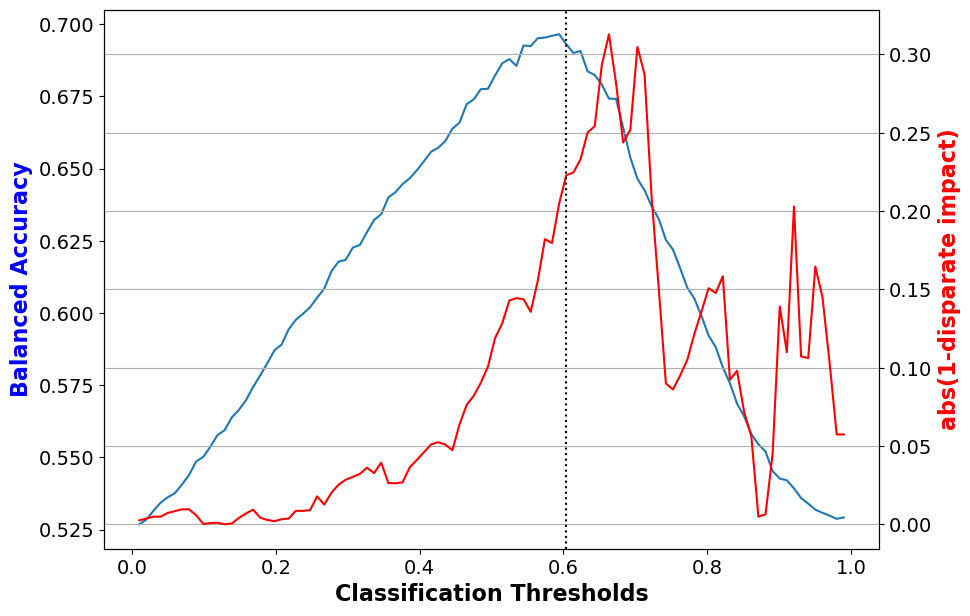

In [80]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

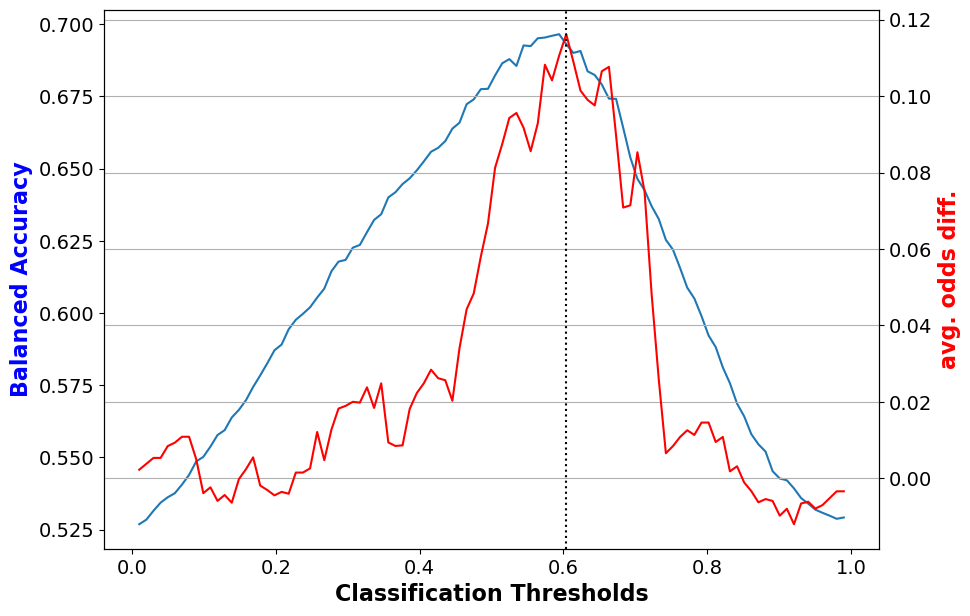

In [81]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

### Train classifier on transformed data

In [82]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [83]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [84]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.6039


 32%|███▏      | 32/100 [00:00<00:00, 312.47it/s]

Balanced accuracy = 0.6909
Statistical parity difference = 0.1384
Disparate impact = 1.2823
Average odds difference = 0.1142
Equal opportunity difference = 0.1555
Theil index = 0.2581


100%|██████████| 100/100 [00:00<00:00, 385.14it/s]


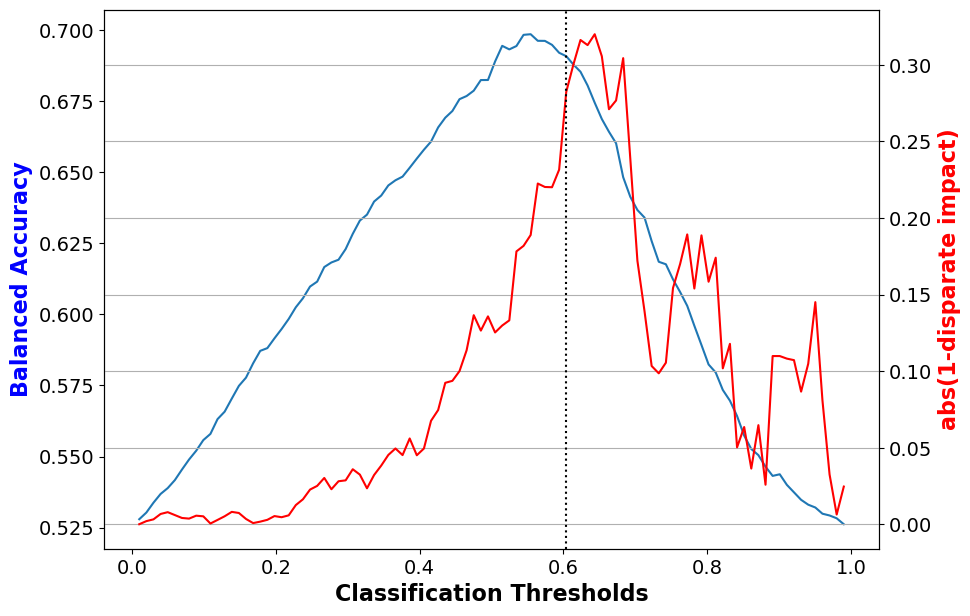

In [85]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

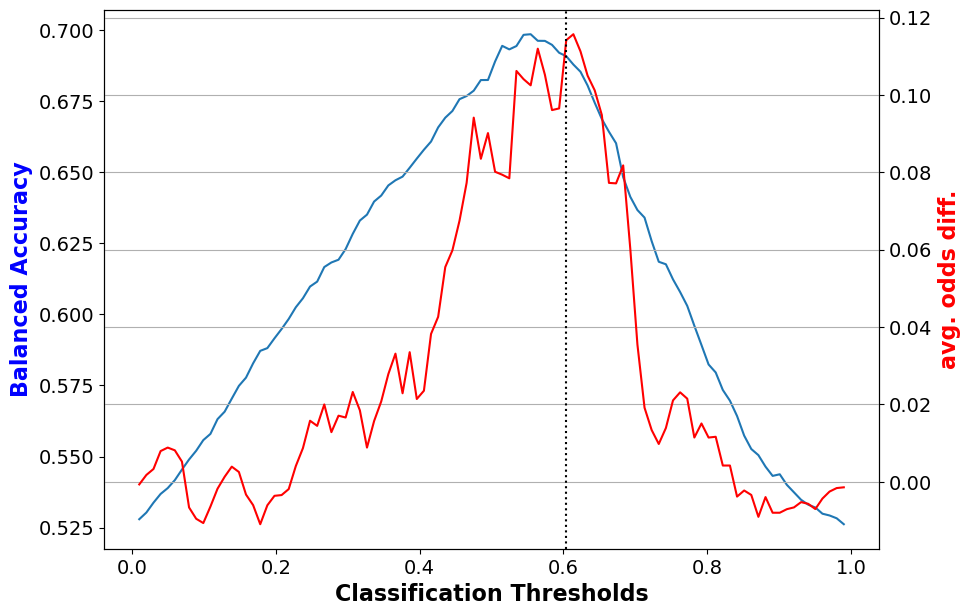

In [86]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)